## Importing the packages

In [1]:
import os 
from dotenv import load_dotenv
load_dotenv()

from langgraph.graph import StateGraph , START , END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage , AIMessage , SystemMessage
from typing import TypedDict , Annotated
from pydantic import BaseModel , Field

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model="gemini-2.5-pro", temperature=0)

## Part 1: Understanding pydantic validations

In [3]:
class Country(BaseModel):

    """Information about a country"""

    name: str = Field(description="name of the country")
    animal: str = Field(description="National animal of the country")
    capital: str = Field(description="Capital of the country")
 
structured_llm = model.with_structured_output(Country)

In [4]:
structured_llm.invoke("what is the capital of india and animal of india")

Country(name='India', animal='Tiger', capital='New Delhi')

In [5]:
response = structured_llm.invoke("what is the capital of india and langugae of india")
print(response)

name='India' animal='Tiger' capital='New Delhi'


## Part 2 : Validation using TypedDict

In [19]:
from typing_extensions import Annotated, TypedDict
from typing import Optional

# TypedDict
class Joke(TypedDict):
    """Joke to tell user."""

    setup: Annotated[str, ..., "The setup of the joke"]
    punchline: Annotated[str, ..., "The punchline of the joke"]
    rating: Annotated[Optional[int], None, "How funny the joke is, from 1 to 10"]


structured_llm = model.with_structured_output(Joke)
structured_llm.invoke("Tell me a joke about cats")

{'setup': "Why don't cats play poker in the jungle?",
 'punchline': 'Too many cheetahs!',
 'rating': 7}

## sample code

In [27]:
class State(TypedDict):
    messages :Annotated[list , add_messages]

In [35]:
def response_from_llm(state:State):
    response = model.invoke(state["messages"])
    return {"messages" : [response]}


In [36]:
workflow = StateGraph(State)

workflow.add_node("llm" , response_from_llm)

workflow.add_edge(START , "llm")
workflow.add_edge("llm" , END)

app = workflow.compile()

In [37]:

app.invoke({"messages" : "what is langgraph?"})

{'messages': [HumanMessage(content='what is langgraph?', additional_kwargs={}, response_metadata={}, id='ba2bfc7f-3415-4df9-a619-27a34231f47e'),
  AIMessage(content='LangGraph is a framework or tool designed to facilitate the creation, visualization, and management of language models and natural language processing (NLP) workflows using graph-based representations. It allows users to build complex language processing pipelines by connecting various components (such as tokenizers, parsers, transformers, and other NLP modules) as nodes in a graph, enabling more intuitive design, debugging, and optimization of language-related tasks.\n\nBy representing language models and their operations as graphs, LangGraph helps in understanding the flow of data and transformations applied at each step, making it easier to customize and extend NLP applications. This approach is particularly useful for researchers and developers working on modular and interpretable language systems.\n\nIf you have a spe

## Part 3: using Pydantic validations in langgraph

In [6]:
#define the state
class GraphState(TypedDict):
    messages : Annotated[list, add_messages]
    code_content : Annotated[str, None]
    quality_score : Annotated[int, None]
    num_words : Annotated[int, None]

In [7]:
# model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [8]:
#defining class
class GenerateCode(BaseModel):
    """ 
    Extract the generated code and the num of words in the code
    """
    code : str = Field(description="Generated software code")
    num_words : int = Field(description="Number of words in the generated code")

developer_structured_llm = model.with_structured_output(GenerateCode)

In [9]:
class EvaluateCode(BaseModel):
    """
    Evaluate the generated code and return the quality score and comments
    """
    comments : str = Field(description="Comments on the quality score")
    quality_score : int = Field(description="Quality score of the generated code between 0 and 100")

evaluator_structured_llm = model.with_structured_output(EvaluateCode)

In [10]:
# Nodes definition

#set the initial state
def init(state):
    print("----------- Init node ------------")
    print("State: ", state)
    return {
        "messages": [] , 
        "quality_score": 0 , 
        "num_words": 0
    }

In [11]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
developer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a software developer. You are given a task to generate a software code.
You will be given a task and you will need to generate a software code for the task.
Respond in json format with the following keys:
code: The generated software code
num_words: The number of words in the generated code""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
#creating chain
developer_chain = developer_prompt | developer_structured_llm

#create a developer node 
def generate_code(state):
    developer_output = developer_chain.invoke({"messages": state["messages"]})
    print("Code generated by developer: ", developer_output.code)
    return {
        "messages": [AIMessage(content=developer_output.code)] , 
        "num_words": developer_output.num_words,
        "code_content": developer_output.code
    }

In [12]:
evaluator_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a high standard code reviewer. You will be given a code and you will need to evaluate the code and return the quality score and comments.
The quality score should be between 0 and 100.
Assess the structure , code quality and documentation of the code.
Respond in json format with the following keys:
comments: Comments on the quality score
quality_score: Quality score of the generated code between 0 and 100
            """,
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
evaluator_chain = evaluator_prompt | evaluator_structured_llm

#create a evaluator node 
def evaluate_code(state):
    evaluator_output = evaluator_chain.invoke({"messages": state["messages"]})
    print("Code evaluated by evaluator: ", evaluator_output.comments)
    return {
        "comments": evaluator_output.comments , 
        "quality_score": evaluator_output.quality_score
    }

In [13]:
def summary(state):
    print("----------- Summary node ------------")
    print("Summary: ", state)
    return state

In [15]:
workflow = StateGraph(GraphState)
workflow.add_node("init" , init)
workflow.add_node("generate_code" , generate_code)
workflow.add_node("evaluate_code" , evaluate_code)
workflow.add_node("summary" , summary)
workflow.add_edge(START , "init")
workflow.add_edge("init" , "generate_code")
workflow.add_edge("generate_code" , "evaluate_code")
workflow.add_edge("evaluate_code" , "summary")
workflow.add_edge("summary" , END)
app = workflow.compile()

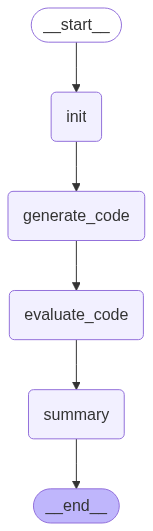

In [16]:
app 

In [17]:

if __name__ == "__main__":

    import json
    import os

    output_dir = "part3_pydantic_validations"
    os.makedirs(output_dir, exist_ok=True)

    while True:
        user_input = input("Enter your coding task: ")
        if user_input.lower() == "exit":
            break
        result = app.invoke({"messages": [HumanMessage(content=user_input)]})
        print("**************************")
        print(json.dumps(result, default=str, indent=2))
        # Dump the result as JSON in the part3_pydantic_validations folder
        output_path = os.path.join(output_dir, "result.json")
        with open(output_path, "w") as f:
            json.dump(result, f, default=str, indent=2)
        print(f"Result dumped to {output_path}")

----------- Init node ------------
State:  {'messages': [HumanMessage(content='write a tree traversal code using python', additional_kwargs={}, response_metadata={}, id='5cfe6ebf-0b35-4c89-bb5c-2f476cfde130')]}
Code generated by developer:  
class Node:
    def __init__(self, key):
        self.left = None
        self.right = None
        self.val = key

def print_inorder(root):
    if root:
        print_inorder(root.left)
        print(root.val, end=" ")
        print_inorder(root.right)

def print_postorder(root):
    if root:
        print_postorder(root.left)
        print_postorder(root.right)
        print(root.val, end=" ")

def print_preorder(root):
    if root:
        print(root.val, end=" ")
        print_preorder(root.left)
        print_preorder(root.right)

root = Node(1)
root.left = Node(2)
root.right = Node(3)
root.left.left = Node(4)
root.left.right = Node(5)

print("Preorder traversal of binary tree is")
print_preorder(root)

print("\nInorder traversal of binary tre